# 1. Automatically scrape job postings of a competitor

We will now see scraping in action. Imagine you are working in HR for a major retailer. Your boss asks you to monitor the strategic hiring decisions of your close competitors. Naturally, you cannot go and call them up - but you could take a look at their job postings to see ($i$) how much they are hiring, ($ii$) what types of positions they are hiring for.

Now, you could log onto their website every day, see what job postings there are, compare that with the job postings from before, and save the relevant data. But why go through so much effort if we can just automate the task?

## 1.1 A simple case - using BeautifulSoup

The first example relies purely on what we have learned about BeautifulSoup and Requests (and a bit of Pandas!).

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

We are searching for positions in the head office of Aldi. On the website, we see that there are different types of head office positions, each with their own website. Let's get the links to those sub-sites.

In [4]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1,IE=8" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="yes" name="mobile-web-app-capable"/>
<style>html{visibility: hidden;opacity:0;}</style>
<link as="style" href="/dist/css/screen.css?v=5" rel="preload"/>
<link as="script" href="/dist/js/commons.js?v=5" rel="preload"/>
<link as="script" href="/dist/js/main.js?v=5" rel="preload"/>
<link href="https://cc.cdn.civiccomputing.com" rel="preconnect">
<link href="https://apikeys.civiccomputing.com" rel="preconnect">
<link href="https://www.google-analytics.com" rel="preconnect">
<link href="https://www.googletagmanager.com" rel="preconnect"/>
<link href="/dist/css/screen.css?v=5" rel="stylesheet" type="text/css"/>
<title>Head Office | Aldi Recruitment UK</title>
<meta content="en_GB" property="og:locale">
<meta content="website" property="og:typ

In [5]:
links = []
for link in soup.findAll('a'):
    links.append(link.get('href'))
print(links)

[None, '/', None, '/', '/about-us/', '/stores/', '/stores/', '/stores/store-manager/', '/stores/assistant-store-manager/', '/stores/deputy-store-manager/', '/stores/store-assistant/', '/stores/stock-assistant/', '/stores/caretaker-cleaner/', '/head-office/', '/warehouse-transport/', '/area-manager-programme/', '/area-manager-programme/', '/area-manager-programme/graduate-area-manager-programme/', '/area-manager-programme/career-changers/', '/placement-programmes/', '/apprenticeships/', '/contact-us/#contact-us', '/about-us/#equality-and-diversity', '/about-us/#right-to-work', 'https://www.aldi.co.uk/', '/privacy-notice-cookies/', 'https://www.facebook.com/AldiCareersUK', 'https://www.youtube.com/user/AldiUK', 'https://twitter.com/AldiCareersUK', 'https://www.linkedin.com/company/aldi-uk', 'https://www.instagram.com/aldiCareersuk', '/job-search/', '/', '/job-search/', '/job-search/', '/job-search/', '/head-office/national-administration/', '/head-office/regional-administration/', '/head

We want to get only the links to actual job postings, so we have to clean the results somewhat:

In [6]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
links = []
for link in soup.findAll('a'):
    new_link = link.get('href')
    if new_link != None and new_link.startswith('/head-office/'):
        links.append(new_link)
print(links)

['/head-office/', '/head-office/national-administration/', '/head-office/regional-administration/', '/head-office/national-buying/', '/head-office/corporate-responsibility/', '/head-office/customer-service/', '/head-office/ecommerce/', '/head-office/global-business-coordination/', '/head-office/hr/', '/head-office/it/', '/head-office/marketing-communications/', '/head-office/merchandising-category/', '/head-office/national-property/', '/head-office/supply-chain-management/', '/head-office/quality-assurance/', '/head-office/quality-control/']


As we use "../head-office" as our base url, we do not need to repeat it. Accordingly, we make a few final adjustments to the link collection.

In [24]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
links = []
for link in soup.findAll('a'):
    new_link = link.get('href')
    # links.append(new_link)
    if new_link != None and new_link.startswith('/head-office/'):
        new_link = new_link.replace('/head-office','')
        # links.append(new_link)
        if new_link != '/':
            links.append(new_link)
print(links)

['/national-administration/', '/regional-administration/', '/national-buying/', '/corporate-responsibility/', '/customer-service/', '/ecommerce/', '/global-business-coordination/', '/hr/', '/it/', '/marketing-communications/', '/merchandising-category/', '/national-property/', '/supply-chain-management/', '/quality-assurance/', '/quality-control/']


In [9]:
url+links[0]

'https://www.aldirecruitment.co.uk/head-office/national-administration/'

Let's see how many postings there are on one of the sub-sites. For this, we have to find the right tags, using their class argument. Again, inspecting the site is very important!

In [8]:
category_url = url + links[0]
page = requests.get(category_url)
soup = BeautifulSoup(page.content, "html.parser")
postings = soup.findAll("div", class_="c-career--dropdown")
len(postings)

14

We now extract some information from the actual position: the job title.

In [10]:
title = postings[0].find("div", class_="c-career--dropdown__content").find('h2')
print(title.text)

National Finance & Administration Manager


Aside from the title and the text description (which we will ignore in this example, but which can hold extremely useful information), there are some key details about the job, such as the work time and the salary.

In [11]:
details = postings[0].findAll("div", class_="c-job-details__content")
print(details)

[<div class="c-job-details__content">
<img data-replace="false" src="/media/xjpjb1m0/market.svg" width="56">
<div>
<span class="c-job-details__title">Salary</span>
<div class="c-job-details__text"><p>£54,285 rising in increments to £79,040 in year 4.</p></div>
</div>
</img></div>, <div class="c-job-details__content">
<img data-replace="false" src="/media/ygxa0wif/island.svg" width="56"/>
<div>
<span class="c-job-details__title">Holiday allowance</span>
<div class="c-job-details__text"><p>5 weeks’ annual leave plus Bank Holidays.</p></div>
</div>
</div>, <div class="c-job-details__content">
<img data-replace="false" src="/media/e4pnj4sn/health.svg" width="56"/>
<div>
<span class="c-job-details__title">Hours and benefits</span>
<div class="c-job-details__text"><p>You’ll work a 50-hour week, working from Monday – Friday. Plus, you’ll receive a company pension when you start, private employee medical insurance after 6 months, company maternity and adoption leave from commencement as well a

We definitely want to get the salary information. Sometime, the text gives multiple values, so let's make sure to save the lowest and the highest value (of course, multiple values may be due to changes over time or for different starting requirements - we can adapt our scraper to capture arbitrary complexity later on).

In [12]:
detail = details[0]
detail_text = detail.find('div', class_="c-job-details__text").text
print(detail_text)

£54,285 rising in increments to £79,040 in year 4.


In [14]:
temp = detail_text.replace(',','')
temp = temp.replace('-','')
temp = temp.split()
temp

['£54285', 'rising', 'in', 'increments', 'to', '£79040', 'in', 'year', '4.']

In [13]:
temp = detail_text.replace(',','')
temp = temp.replace('-','')
temp = temp.split()
salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
ub = max(salary_numbers)
lb = min(salary_numbers)
print(ub)
print(lb)

79040.0
54285.0


Let's also try to capture the weekly working hours:

In [18]:
detail = details[2]
detail_text = detail.find('div', class_="c-job-details__text").text
for s in detail_text.split():
    print(s)

You’ll
work
a
50-hour
week,
working
from
Monday
–
Friday.
Plus,
you’ll
receive
a
company
pension
when
you
start,
private
employee
medical
insurance
after
6
months,
company
maternity
and
adoption
leave
from
commencement
as
well
as
company
paternity
pay
after
2
years.


In [16]:
detail = details[2]
detail_text = detail.find('div', class_="c-job-details__text").text
for s in detail_text.split():
    if '-hour' in s:
        work_time = s
        work_time = int(work_time.replace('-hour',''))
print(work_time)

50


The following code combines our extraction of job details:

In [19]:
details = postings[0].findAll("div", class_="c-job-details__content")
for detail in details:
    detail_title = detail.find('span', class_="c-job-details__title").text
    detail_text = detail.find('div', class_="c-job-details__text").text
    if detail_title == 'Salary':
        temp = detail_text.replace(',','')
        temp = temp.replace('-','')
        temp = temp.split()
        salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
        ub = max(salary_numbers)
        lb = min(salary_numbers)
    elif detail_title == 'Hours and benefits':
        for s in detail_text.split():
            if '-hour' in s:
                work_time = s
                work_time = int(work_time.replace('-hour',''))
print(ub)
print(lb)
print(work_time)

79040.0
54285.0
50


Finally, we are putting it all together into a simple-to-call function that returns a data frame of job postings. We have to make a few adjustments to avoid errors. These are marked with comments.

In [20]:
def scrape_aldi_jobs(starting_page = 'head-office'):
    url = "https://www.aldirecruitment.co.uk/" + starting_page
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/'):
            new_link = new_link.replace('/head-office','')
            if new_link != '/':
                links.append(new_link)
    
    department = []
    titles = []
    ubs = []
    lbs = []
    hours = []
    for link in links:
        category_url = url + link
        page = requests.get(category_url)
        soup = BeautifulSoup(page.content, "html.parser")
        postings = soup.findAll("div", class_="c-career--dropdown")
        for posting in postings:
            ## Also grabbing the department information
            dep_name = link.replace('-',' ').replace('/','')
            department.append(dep_name)
            titles.append(posting.find("div", class_="c-career--dropdown__content").find('h2').text)
            details = posting.findAll("div", class_="c-job-details__content")
            for detail in details:
                detail_title = detail.find('span', class_="c-job-details__title").text
                detail_text = detail.find('div', class_="c-job-details__text").text
                if detail_title == 'Salary':
                    temp = detail_text.replace(',','')
                    temp = temp.replace('-','')
                    temp = temp.split()
                    salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
                    ## Salary may not be specified
                    if len(salary_numbers) > 0:
                        ## Salaries are sometimes specified as per week instead of per year
                        if 'per' in temp and 'week' in temp:
                            salary_numbers = [salary*52 for salary in salary_numbers]
                        ubs.append(max(salary_numbers))
                        lbs.append(min(salary_numbers))
                    else:
                        ubs.append(None)
                        lbs.append(None)
                ## Some postings say "Benefits" instead of "Hours and benefits", and sometimes the spelling is capitalized differently
                elif detail_title.lower() == 'hours and benefits' or detail_title.lower() == 'benefits':
                    ## Some postings do not specify a number of hours per week
                    work_time = None
                    for s in detail_text.split():
                        if '-hour' in s:
                            work_time = s
                            ## Some postings write, e.g., 40-hour per week, some 40-hours per week
                            if '-hours' in s:
                                work_time = int(work_time.replace('-hours',''))
                            else:
                                work_time = int(work_time.replace('-hour',''))
                    hours.append(work_time)
                        
    job_data = pd.DataFrame(
        {'Department': department,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,
         'Weekly hours': hours
        })
    return job_data

Let's try it out:

In [25]:
aldi_job_data = scrape_aldi_jobs()
aldi_job_data.head()

,Department,Job title,Salary lower,Salary upper,Weekly hours
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0
1,national administration,National Tax Manager,44660.0,93655.0,50.0
2,national administration,Data Scientist,57.0,74430.0,40.0
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0
4,national administration,Technical Analyst,47100.0,54255.0,40.0


We can now explore the data frame, improve our code if we find issues, and then analyze it. For example, let's have a look at a simple histogram of postings per department.

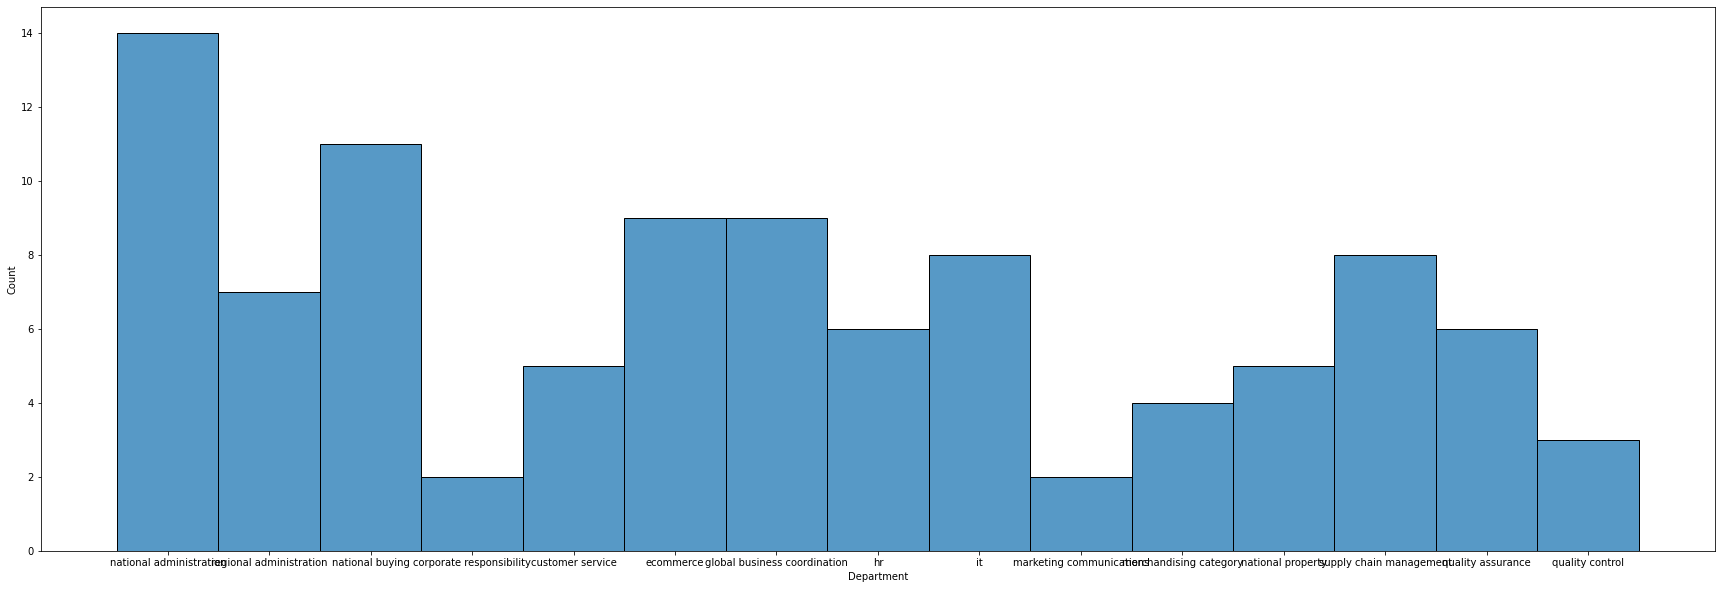

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.histplot(data=aldi_job_data, x="Department",ax=ax)
plt.show()

Finally, save the job postings we found as a CSV:

In [27]:
aldi_job_data.to_csv('Aldi_postings_2021-10-14.csv', index=False)

## Exercise 1

Can you correct the scraping function to avoid issues with the salary or weekly hour number? Define a new function `scrape_aldi_jobs_corrected`, in which you eliminate any issues you come across in the data.

## Exercise 2

The idea is that we run our code regularly and observe the current postings. For this, we need to do the following:
1. Load an existing csv file with job postings (on Moodle)
2. For any job currently found on the website, check whether it was already posted previously (for simplicity, only compare Department and Job title)
3. If the job posting is new, add today as the posting date in the data frame. Otherwise, add the date of the previous file

## 1.2 A more advanced case - using Selenium to enter details

Let's get data from a second competitor. We will use Lidle here (I am, of course, not biased in my choices). Check out Lidl's hiring page https://careers.lidl.co.uk/ and start a search. Then look at the link where you landed at - can you see why things are a bit more complex here?

Since we cannot just find the right links, we need to act like a browser. This is where Selenium comes in - it will literally run a browser!

In [ ]:
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
import pandas as pd
import re
import time

We need to choose the type of browser that Selenium runs - and each comes with its own access and installation requirements. I personally recommend using Chrome. However, to use Chrome, with Selenium, you need to install ChromeDriver. The site https://sites.google.com/chromium.org/driver/downloads gives download files, which should work fine for Windows users. Simply download and unpack the Zip, which gives you a .exe file. Either move it somewhere on your PATH, or add it to your path (https://stackoverflow.com/questions/4822400/register-an-exe-so-you-can-run-it-from-any-command-line-in-windows gives a good description how to).

On Mac, you may run into access issues. The easiest way to proceed is to use Homebrew (https://brew.sh/ shows how to use it). Once done, type
```
brew install chromedriver
```
into your terminal.
Other options can be found here: https://www.kenst.com/2015/03/installing-chromedriver-on-mac-osx/ (note that the syntax can be a bit outdated).

Once done, the below code will open a new window in the browser of your choice (here Chrome):

In [ ]:
driver = webdriver.Chrome()
driver.get("https://careers.lidl.co.uk/jobsearch")

You will notice that this is a completely new Chrome process - so cookies are not yet accepted. To see what's going on, let's start by accepting cookies. How do we do this? We simply find the right button (by insepcting the site, then copying the XPath), and then let Selenium click this button!

In [ ]:
cookie_button = driver.find_element_by_xpath('//*[@id="CybotCookiebotDialog"]/div/div[1]/button')
cookie_button.click()

The Lidl jobs site offers the option to select head office positions, just like Aldi. However, the link is relatively complex, so we will simply let Selenium click on the right button again.

In [ ]:
head_office_button = driver.find_element_by_xpath('//*[@id="react-container"]/div[3]/div/div/div/div/div[1]/div/a')
head_office_button.click()

There are a few positions here. If you click on any of those, you'll notice that the links are relatively simple in structure and don't depend on your website interaction. Hence, the easiest is for us to collect all the posting links

In [ ]:
posting_urls = []
postings = driver.find_elements_by_class_name('jobResult')
for posting in postings:
    posting_urls.append(posting.get_attribute('href'))

It may be that postings are spread across multiple pages (delete the filters to see this). Luckily, there is a forward button that let's us scroll through the pages. We can easily combine this with our previous code. Note that we only move forward if the next page element actually exists.
There can be a problem with identifying the button location. Usually, this can be fixed by maximizing the window in which Selenium runs.


Also, we add an implict wait so that the server has time to respond before our clicks.

In [ ]:
stop = False
posting_urls = []
while not stop:
    driver.implicitly_wait(5)
    postings = driver.find_elements_by_class_name('jobResult')
    print("Found " + str(len(postings)) + " postings")
    for posting in postings:
        posting_urls.append(posting.get_attribute('href'))
    next_elements = driver.find_elements_by_class_name('paginationArrow_next')
    if len(next_elements) > 0:
        element = driver.find_element_by_class_name('paginationArrow_next')
        if element.is_enabled():
            driver.execute_script("arguments[0].click();", element)
            time.sleep(3)
        else:
            stop = True
    else:
        stop = True

## Exercise 3 - we will get back to this one during the tutorial

Now that we have loaded the urls of the relevant vacancies, can you extract some key information (e.g., title and postcode of location)? This will be similar to what we did for the Aldi vacancies.

# 2. Basics of classes

Let's start by defining the class `Car`. No matter the car, it will have a make, a model, a number of horsepowers, and a (maximum) speed. So we can use these attributes to define objects of our class:

In [28]:
class Car():
    # initialization function
    def __init__(self, make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed

We can now define an object, for example, a Toyota Camry with 100 horse power and a maximum speed of 120 (miles/hour)

In [29]:
car1 = Car("Toyota","Camry",100,120)

When coding, we often print out "things", at the very least to debug. Let's see what happens when we print out our object:

In [30]:
print(car1)

To adjust how an object is represented as a string, we (re)define the `__str__` method:

In [31]:
class Car():
    def __init__(self,make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed
    def __str__(self):
        return "Make: " + self.make + ", Model: " + self.model + ", Horse Power: " + str(self.hp) + ", Speed: " + str(self.speed)

Now we should get something more descriptive:

In [32]:
car2 = Car("Toyota","Camry",100,120)
print(car2)

Make: Toyota, Model: Camry, Horse Power: 100, Speed: 120


Note that a string method *should* be unique to the specific object. If we have two `Car` objects that are different, they should also return a different string.

We can also access the attributes of our `Car` objects:

In [33]:
print(car2.speed)

120


And, since we can access the attributes, we can also set them to different values:

In [34]:
car2.speed = 130

In [35]:
print(car2.speed)

130


However, you should not change objects like this (because you may be changing things that the developer of the class doesn't want you to change, so that the code can continue running smoothly). Commonly, if you can safely change an object's attribute, there will be a "setter" method to do so. In this method, the developer may add in some safety checks to ensure your change is valid. Also, you should be using "getter" methods to call up attributes.

In [37]:
class Car():
    def __init__(self,make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed
    def __str__(self):
        return "Make: " + self.make + ", Model: " + self.model + ", Horse Power: " + str(self.hp) + ", Speed: " + str(self.speed)
    def set_speed(self,speed):
        if speed > 0:
            self.speed = speed
        else:
            print("invalid speed")
    def get_speed(self):
        return self.speed

Let's create another car

In [38]:
car3 = Car("Toyota","Camry",100,120)

Now, try to set the speed to something invalid: this will not work (rightly so!)

In [39]:
car3.set_speed(-10)

invalid speed


We can confirm that nothing changed, by either calling the attribute directly (not recommended), or calling the "getter" method (recommended):

In [40]:
car3.get_speed()

120

By directly accessing the `speed` attribute, however, we can set it to something invalid:

In [41]:
car3.speed = -10

In fact, the maximum speed is now negative!

In [42]:
print(car3.get_speed())

-10


Let's correct this - with the "setter" method:

In [43]:
car3.set_speed(130)

Finally, we check again, using the "getter" method:

In [44]:
print(car3.get_speed())

130


We can also use our objects as input to a method. For example, let's see whether our `Car` object is fast:

In [45]:
def is_car_fast(car):
    if car.get_speed() > 130:
        return True
    else:
        return False

In [46]:
print(is_car_fast(car3))

False


An important part of object-oriented programming is the ability to inherit. For example, just as we can make `Car` objects, we can make `Ford` objects. But any `Ford` is also a `Car`! In Python, inheritance is marked by adding another class as parameter to the class we are programming:

In [47]:
class Ford(Car):
    def __init__(self, model, hp, speed):
        Car.__init__(self, "Ford", model, hp, speed)

In our case above, when we create a `Ford`, we create a `Car` with `"Ford"` as the make. Le'ts try it out:

In [48]:
ford1 = Ford("Focus",80,110)

In [49]:
print(ford1)

Make: Ford, Model: Focus, Horse Power: 80, Speed: 110


In [50]:
print(type(ford1))

<class '__main__.Ford'>


## Exercise 4

Define a class `Person`, as follows:
1. define an `__init__` method that takes a name and an age as argument and set the corresponding object-attributes
2. define a `get_name` method that returns the name of the `Person`-object

Next, define a class `Organization`:
1. the class should have an `__init__` method, in which an empty object-specific list `hires` gets created
2. the class should also have a `hire` method that takes a `Person` as an input and adds the person to the list of hires
3. finally, the class should have a `__str__` method that returns a string including all the names of the hires

Create two persons with name and age. Then, create an organization, hire the two person, and run `print` on the organization:

# 3. Scrapy

We now turn to `scrapy`. As always, there is a package to import (and install, if you haven't done so already):

In [52]:
import scrapy

We create a spider (which inherits from the `scrapy.Spider`), which starts with two subpages of http://quotes.toscrape.com/. Every time our spider parses a webpage, it simply saves the entire HTML document locally:

In [53]:
class QuotesSpider(scrapy.Spider):
    name = "quotes"

    start_urls = [
        'http://quotes.toscrape.com/page/1/',
        'http://quotes.toscrape.com/page/2/',
    ]

    def parse(self, response):
        page = response.url.split("/")[-2]
        filename = f'quotes-page{page}.html'
        with open(filename, 'wb') as f:
            f.write(response.body)
        self.log(f'Saved file {filename}')

Usually, we run spiders from the terminal (we will see how to do this later). However, we can run the spider from a Jupyter notebook - once:

In [54]:
from scrapy.crawler import CrawlerProcess

In [56]:
process = CrawlerProcess()
process.crawl(QuotesSpider)
process.start()

2021-10-14 12:36:14 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: scrapybot)
2021-10-14 12:36:14 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 21.2.0, Python 3.8.2 (default, Mar 25 2020, 11:22:43) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 20.0.1 (OpenSSL 1.1.1l  24 Aug 2021), cryptography 3.4.7, Platform macOS-10.16-x86_64-i386-64bit
2021-10-14 12:36:14 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2021-10-14 12:36:14 [scrapy.crawler] INFO: Overridden settings:
{}
2021-10-14 12:36:14 [scrapy.extensions.telnet] INFO: Telnet Password: 6c9f3985730bfb43
2021-10-14 12:36:14 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2021-10-14 12:36:14 [scrapy.middleware] INFO: Enabled downloader middlewares:
['sc

ReactorNotRestartable: 

But try doing this again (without restarting the kernel), and you are likely to run into problems. There are, in principle, ways around this, but they are quite tedious. So let's take a look at running `scrapy` from the terminal.